In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def fa(x = 1, y = 1, size = (7,7)):
    return plt.subplots(x,y,figsize = size)
plt.ioff()

In [2]:
dn1 = pd.read_csv(r'D:\other studies\Prosperity-3\data\round-2-island-data-bottle\prices_round_2_day_-1.csv', delimiter = ';')
d0 =pd.read_csv(r'D:\other studies\Prosperity-3\data\round-2-island-data-bottle\prices_round_2_day_0.csv', delimiter = ';') 
d1=pd.read_csv(r'D:\other studies\Prosperity-3\data\round-2-island-data-bottle\prices_round_2_day_1.csv', delimiter = ';')

PLAN:
- Determine synthetic baskets price (i.e individual parts) using best ask and best bid
    - for both basket 1 and 2
- Calculate the VWMID of all baskets
- calculate the spread between VWMID's of syn basket x and actual basket x


Future:
- Could trade based on rolling window z scores

In [ ]:
d0

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,RAINFOREST_RESIN,9992,30,NaN,NaN,NaN,NaN,10008,30,NaN,NaN,NaN,NaN,10000.0,0.0
1,0,0,DJEMBES,13493,72,NaN,NaN,NaN,NaN,13494,72,NaN,NaN,NaN,NaN,13493.5,0.0
2,0,0,CROISSANTS,4321,111,NaN,NaN,NaN,NaN,4322,111,NaN,NaN,NaN,NaN,4321.5,0.0
3,0,0,JAMS,6631,210,NaN,NaN,NaN,NaN,6633,210,NaN,NaN,NaN,NaN,6632.0,0.0
4,0,0,KELP,2028,30,NaN,NaN,NaN,NaN,2032,30,NaN,NaN,NaN,NaN,2030.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0,999900,PICNIC_BASKET2,30255,2,30254.0,34.0,NaN,NaN,30260,18,30261.0,18.0,NaN,NaN,30257.5,0.0
79996,0,999900,CROISSANTS,4275,124,NaN,NaN,NaN,NaN,4276,124,NaN,NaN,NaN,NaN,4275.5,0.0
79997,0,999900,JAMS,6541,183,NaN,NaN,NaN,NaN,6543,183,NaN,NaN,NaN,NaN,6542.0,0.0
79998,0,999900,DJEMBES,13409,64,NaN,NaN,NaN,NaN,13410,64,NaN,NaN,NaN,NaN,13409.5,0.0


In [62]:
def syn_basket1(data):
    croissants = data[data['product'] == 'CROISSANTS'].reset_index(drop=True)
    jams = data[data['product'] == 'JAMS'].reset_index(drop=True)
    djembes = data[data['product'] == 'DJEMBES'].reset_index(drop=True)
    best_bid = 6*croissants['bid_price_1'] + 3*jams['bid_price_1'] + djembes['bid_price_1']
    best_ask = 6*croissants['ask_price_1'] + 3*jams['ask_price_1'] + djembes['ask_price_1']
    bid_vol = pd.DataFrame([croissants['bid_volume_1'],jams['bid_volume_1'],djembes['bid_volume_1']]).min(axis=0).apply(lambda x: x//6)
    ask_vol = pd.DataFrame([croissants['ask_volume_1'],jams['ask_volume_1'],djembes['ask_volume_1']]).min(axis=0).apply(lambda x: x//6)
    result = pd.DataFrame({'best_bid': best_bid, 'best_ask': best_ask, 'bid_vol': bid_vol, 'ask_vol': ask_vol})
    result['mid'] = result['best_bid']*result['bid_vol']+result['best_ask']*result['ask_vol']
    result['mid'] = result['mid']/(result['bid_vol']+result['ask_vol'])
    return result


def syn_basket2(data):
    croissants = data[data['product'] == 'CROISSANTS'].reset_index(drop=True)
    jams = data[data['product'] == 'JAMS'].reset_index(drop=True)
    best_bid = 4*croissants['bid_price_1'] + 2*jams['bid_price_1']
    best_ask = 4*croissants['ask_price_1'] + 2*jams['ask_price_1']
    bid_vol = pd.DataFrame([croissants['bid_volume_1'],jams['bid_volume_1']]).min(axis=0).apply(lambda x: x//4)
    ask_vol = pd.DataFrame([croissants['ask_volume_1'],jams['ask_volume_1']]).min(axis=0).apply(lambda x: x//4)
    result = pd.DataFrame({'best_bid': best_bid, 'best_ask': best_ask, 'bid_vol': bid_vol, 'ask_vol': ask_vol})
    result['mid'] = result['best_bid']*result['bid_vol']+result['best_ask']*result['ask_vol']
    result['mid'] = result['mid']/(result['bid_vol']+result['ask_vol'])
    return result

def spread(data):

    # calculate mid price for each basket
    basket1 = data[data['product'] == 'PICNIC_BASKET1'].reset_index(drop=True).fillna(0)
    basket1['mid'] = basket1['bid_price_1']*basket1['bid_volume_1'] + basket1['bid_price_2']*basket1['bid_volume_2'] + basket1['bid_price_3']*basket1['bid_volume_3']  
    basket1['mid'] += basket1['ask_price_1']*basket1['ask_volume_1'] + basket1['ask_price_2']*basket1['ask_volume_2'] + basket1['ask_price_3']*basket1['ask_volume_3']
    basket1['mid'] = basket1['mid']/(basket1['bid_volume_1']+basket1['bid_volume_2']+basket1['bid_volume_3']+basket1['ask_volume_1']+basket1['ask_volume_2']+basket1['ask_volume_3'])
    
    basket2 = data[data['product'] == 'PICNIC_BASKET2'].reset_index(drop=True).fillna(0)
    basket2['mid'] = basket2['bid_price_1']*basket2['bid_volume_1'] + basket2['bid_price_2']*basket2['bid_volume_2'] + basket2['bid_price_3']*basket2['bid_volume_3']
    basket2['mid'] += basket2['ask_price_1']*basket2['ask_volume_1'] + basket2['ask_price_2']*basket2['ask_volume_2'] + basket2['ask_price_3']*basket2['ask_volume_3']
    basket2['mid'] = basket2['mid']/(basket2['bid_volume_1']+basket2['bid_volume_2']+basket2['bid_volume_3']+basket2['ask_volume_1']+basket2['ask_volume_2']+basket2['ask_volume_3'])
    
    #compare spread with mid of synthetic basket
    sb1 = syn_basket1(data)
    sb2 = syn_basket2(data)

    # calculate spread for each basket
    basket1['spread'] = (basket1['mid'] - sb1['mid'])
    basket2['spread'] = (basket2['mid'] - sb2['mid'])
    return basket1, basket2


In [72]:
alldays = pd.concat([dn1, d0, d1], axis = 0).reset_index(drop=True)

In [74]:
b1, b2 = spread(alldays)

<Axes: ylabel='spread'>

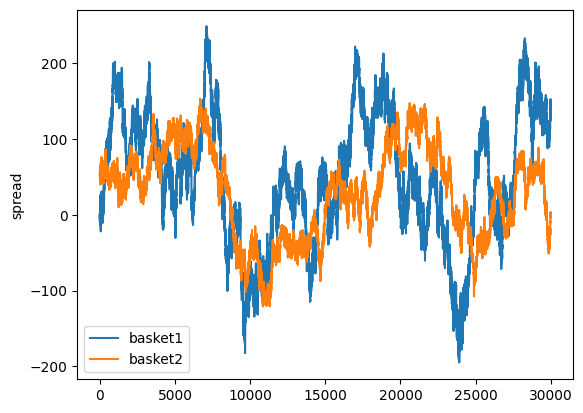

In [75]:
sns.lineplot(b1['spread'], label = 'basket1')
sns.lineplot(b2['spread'], label = 'basket2')

<Axes: xlabel='spread', ylabel='Density'>

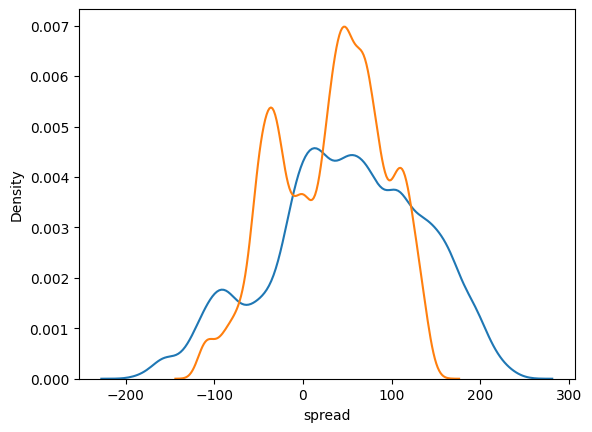

In [77]:
sns.kdeplot(b1['spread'], label = 'basket1')
sns.kdeplot(b2['spread'], label = 'basket2')

## Calculating z scores on rolling window basis

In [105]:
n = 1000 # tune this
b1_spread, b2_spread = spread(alldays)
b1_spread.fillna(0, inplace=True)
b2_spread.fillna(0, inplace=True)

b1_spread['rolling avg'] = b1_spread['spread'].rolling(n).mean().fillna(0)
b1_spread['rolling std'] = b1_spread['spread'].rolling(n).std().fillna(0)
b1_spread['rolling z'] = (b1_spread['spread'] - b1_spread['rolling avg'])/b1_spread['rolling std']

b2_spread['rolling avg'] = b2_spread['spread'].rolling(n).mean().fillna(0)
b2_spread['rolling std'] = b2_spread['spread'].rolling(n).std().fillna(0) 
b2_spread['rolling z'] = (b2_spread['spread'] - b2_spread['rolling avg'])/b2_spread['rolling std']

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
            ...    
29995    121.746380
29996    121.751805
29997    121.751474
29998    121.747107
29999    121.756269
Name: spread, Length: 30000, dtype: float64

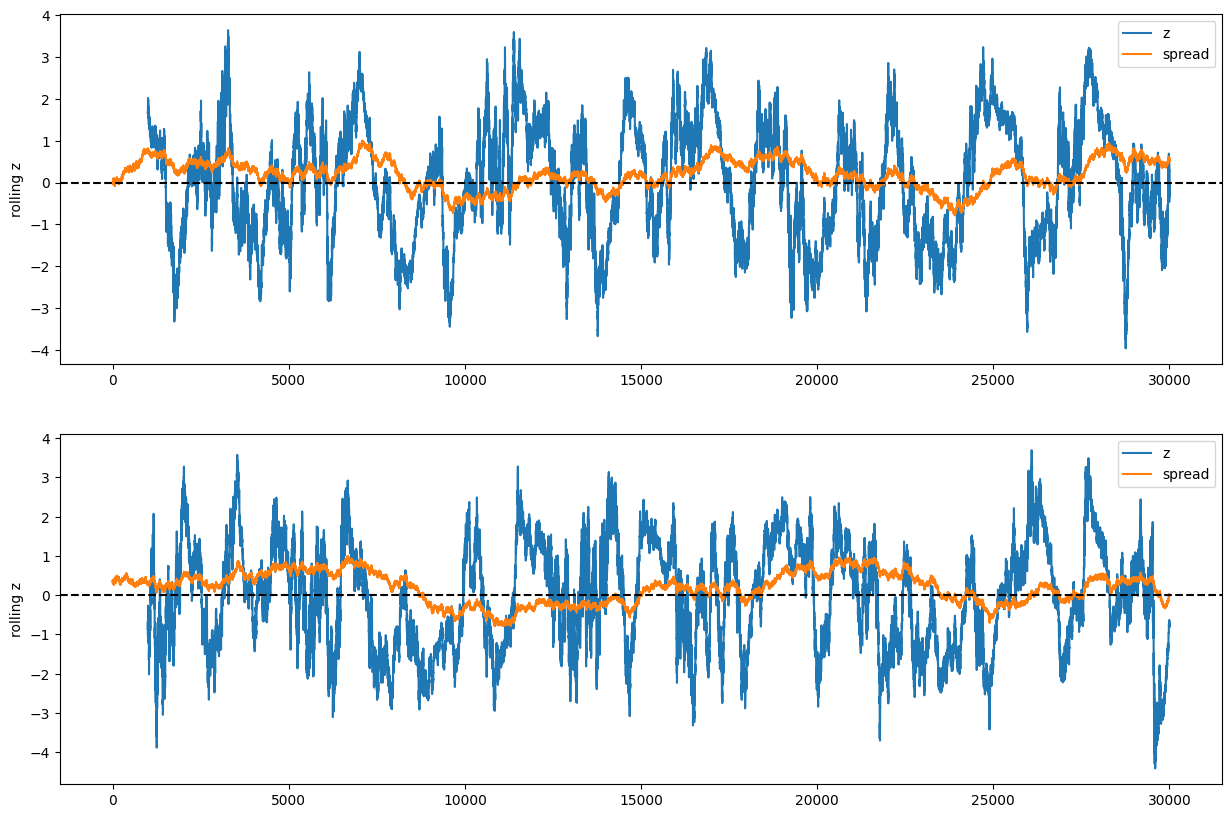

In [104]:
f,a = fa(2,1, (15,10))
sns.lineplot(b1_spread['rolling z'], label = 'z', ax = a[0])
sns.lineplot(b1_spread['spread']/max(b1_spread['spread']), label = 'spread', ax = a[0])
a[0].axhline(0, color = 'black', linestyle = '--')

sns.lineplot(b2_spread['rolling z'], label = 'z', ax = a[1])
sns.lineplot(b2_spread['spread']/max(b2_spread['spread']), label = 'spread', ax = a[1])
a[1].axhline(0, color = 'black', linestyle = '--')